In [1]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [189]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))

# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
for cluster in tz_map:
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']
        
tz_map[4:6]

[{u'id': 5,
  u'name': u'Prospect Park',
  u'taxi_ids': [190],
  u'zillow_ids': [403161]},
 {u'id': 6,
  u'name': u'Brownsville',
  u'taxi_ids': [35],
  u'zillow_ids': [193526]}]

In [154]:
from datetime import date

In [206]:
def get_taxis(weekend_only=False,
              day_normalized=True,
              add_green=True,
              event='DO'):
    # Load the yellow taxi analysis
    yellow = pd.read_csv('yellow_daily.csv', index_col=None, header=None)
    green = pd.read_csv('green_daily.csv', index_col=None, header=None)
    yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                     'passengers', 'distance', 'fare', 'count']
    green.columns = yellow.columns[:]
    
    if add_green:
        combined = pd.concat([yellow, green], axis=0, ignore_index=True)
        combined = combined.groupby(['location_id', 'event', 'year', 'month', 'day'])\
            .sum().reset_index()
        yellow = combined

    is_weekend = []
    SATURDAY = 5
    for y in yellow.itertuples():
        d = date(y.year, y.month, y.day)
        is_weekend.append(d.weekday() >= SATURDAY)
        
    if weekend_only:
        yellow = yellow[is_weekend]

    # What are daily stats for the entire city?
    yellow_citywide = yellow.drop(['location_id'], axis=1)\
        .groupby(by=['event', 'year', 'month', 'day'])\
        .sum().reset_index()
    yellow_citywide = yellow_citywide[yellow_citywide['year'] >= 2013]
    cw = yellow_citywide
    cw = cw[cw['event'] == event]
    cw = cw[cw['year'] < 2017]
    cw = cw[cw['year'] >= 2013]
    cw = cw[['year', 'month', 'day', 'count']]
    cw_mean = cw['count'].mean()
    print(len(cw))

    yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
    
    yellow_composite = yellow.drop('location_id', axis=1)\
        .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
        .sum().reset_index()
        
    available_cluster_ids = list(yellow['composite_id'].unique())
    by_cluster_map = {}
    for cluster_id in available_cluster_ids:
        # Get taxi dropoffs
        yc = yellow_composite
        taxis = yc[yc['composite_id'] == cluster_id]
        taxis = taxis[taxis['event'] == event]
        taxis = taxis[taxis['year'] < 2017]
        taxis = taxis[taxis['year'] >= 2013]
        taxis = taxis[['year', 'month', 'day', 'count']]
        taxis = pd.merge(taxis, cw, on=['year', 'month', 'day'])

        if day_normalized:
            cy = taxis['count_y']
            taxis['count'] = taxis['count_x'].as_matrix() * cw_mean / cy.as_matrix()
        else:
            taxis['count'] = taxis['count_x']
        taxis = taxis[['year', 'month', 'day', 'count']]
            
        taxis = taxis[['year', 'month', 'count']]
        taxis = taxis.groupby(by=['year', 'month']).mean()
        by_cluster_map[cluster_id] = taxis
        
    return yellow_composite, by_cluster_map

In [207]:
yellow = get_taxis(add_green=False)
combined = get_taxis(add_green=True)
combined_no_norm = get_taxis(day_normalized=False)

1461
1461
1461


In [212]:
set(yellow[1].keys()).intersection(yellow[1].keys())

{-1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133}

# Adjust Zillow Rent Prices With Inflation

In [159]:
# Load zillow rent prices
# DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
zillow = pd.read_csv('./Neighborhood_MedianRentalPrice_1Bedroom.csv')
z = zillow
zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
early_cols = [c for c in early_cols if c in zillow.columns]
zillow = zillow.drop(early_cols, axis=1)
zillow.describe()

,SizeRank,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
count,90.000000,85.000000,86.000000,86.000000,86.000000,86.000000,86.000000,87.000000,87.000000,88.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,93.744444,2016.076471,2036.447674,2048.325581,2057.912791,2078.302326,2094.284884,2087.545977,2114.068966,2122.255682,...,2269.927778,2268.516667,2266.350000,2275.455556,2265.605556,2266.338889,2284.277778,2289.950000,2274.866667,2243.255556
std,66.771043,846.657671,830.859817,831.371025,823.442373,831.024832,837.656621,838.071740,834.468307,845.200959,...,832.719872,823.898960,830.618858,829.243122,807.190347,809.049650,803.364380,803.575685,795.287047,788.903852
min,3.000000,975.000000,1000.000000,1050.000000,1050.000000,1012.500000,1040.000000,1050.000000,1050.000000,1050.000000,...,1300.000000,1300.000000,1275.000000,1300.000000,1300.000000,1300.000000,1325.000000,1300.000000,1350.000000,1349.000000
25%,37.500000,1300.000000,1350.000000,1350.000000,1356.250000,1358.125000,1375.000000,1375.000000,1395.000000,1390.625000,...,1599.250000,1600.000000,1595.125000,1596.250000,1600.000000,1600.000000,1606.250000,1600.000000,1631.250000,1600.000000
50%,79.500000,1575.000000,1612.500000,1600.000000,1600.000000,1650.000000,1688.250000,1700.000000,1750.000000,1756.000000,...,1925.750000,1950.000000,1900.000000,1912.500000,1925.000000,1950.000000,1925.000000,2022.500000,1937.500000,1886.250000
75%,137.500000,2800.000000,2875.000000,2871.250000,2875.000000,2868.500000,2905.000000,2910.000000,2925.000000,2925.000000,...,2950.000000,2898.750000,2900.000000,2999.375000,2926.250000,2887.500000,2983.750000,2998.750000,2943.750000,2860.750000
max,262.000000,3895.000000,3795.000000,3825.000000,3895.000000,3895.000000,3995.000000,4025.000000,4012.500000,3995.000000,...,4450.000000,4450.000000,4397.500000,4295.000000,4295.000000,4295.000000,4295.000000,4206.000000,4250.000000,4212.000000


In [160]:
zillow_cols_to_idx = {z: i + 1 for i, z in enumerate(zillow.columns)}
zillow[:3]

,RegionName,City,State,Metro,CountyName,SizeRank,2013-01,2013-02,2013-03,2013-04,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
2,Upper West Side,New York,NY,New York,New York,3,3000.0,2990.0,3000.0,3000.0,...,3260.5,3250.0,3295.0,3225.0,3070.0,3200.0,3239.0,3250.0,3226.0,3180.0
4,Upper East Side,New York,NY,New York,New York,5,2545.0,2500.0,2500.0,2500.0,...,2800.0,2800.0,2795.0,2700.0,2695.0,2700.0,2725.0,2700.0,2695.0,2700.0
5,East New York,New York,NY,New York,Kings,6,1125.0,1175.0,1200.0,1200.0,...,1400.0,1450.0,1500.0,1500.0,1400.0,1350.0,1425.0,1350.0,1500.0,1550.0


In [161]:
# Inflation data
inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
print(inflation.ix[2015]['Jul'])
inflation

238.212


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2013,225.060,225.584,225.745,226.309,227.011,227.330,227.555,227.909,228.343,228.576,229.120,229.626
2014,230.545,231.141,232.096,232.040,232.849,233.092,233.610,233.899,234.177,234.616,235.004,235.456
2015,235.791,236.295,236.586,237.171,237.285,237.768,238.212,238.635,239.133,239.535,239.989,240.303
2016,240.752,241.310,241.641,242.202,242.919,243.459,244.048,244.804,245.595,246.380,246.947,247.616


In [162]:
# Create an array with zillow prices adjusted by inflation.
zillow_inf_adjust = zillow.copy()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
standard = inflation.ix[2016]['Dec']
for year in range(2013, 2017):
    for month in range(1, 13):
        colname = '{}-{:02}'.format(year, month)
        col = zillow_inf_adjust[colname]
        col = standard / inflation.ix[year][months[month - 1]] * col
        zillow_inf_adjust[colname] = col

In [163]:
zillow.to_csv('zillow_ny.csv')
zillow_inf_adjust.to_csv('zillow_inf_adjust.csv')

In [164]:
len(zillow_inf_adjust)

90

In [165]:
# What is the Zillow Neighborhood ID?
zillow_shape = json.load(open('ZillowNeighborhoods-NY_mapshaper.json'))

In [166]:
# Need a mapping from zillow region name to zillow ID
z_name_to_id = {}
for z in zillow_shape['features']:
    prop = z['properties']
    zid = int(prop['RegionID'])
    z_name_to_id[prop['Name']] = prop['RegionID']
    
region_ids = []
for z in zillow_inf_adjust.itertuples():
    regid = z_name_to_id[z.RegionName]
    region_ids.append(regid)
    print(z.RegionName, regid)

Upper West Side 270958
Upper East Side 270957
East New York 194430
Washington Heights 198687
Astoria 272816
Williamsburg 199001
Bedford Stuyvesant 272902
Flatbush 194737
Crown Heights 403222
Jamaica 25294
Harlem 195267
Williamsbridge 343222
East Harlem 270828
Bushwick 193587
East Flatbush 194379
Corona 10957
Sunset Park 270945
Concourse 270817
Elmhurst 403223
Bensonhurst 193285
Soundview 343205
Lower East Side 270875
Flushing 18131
Murray Hill 274627
Sheepshead Bay 403131
Gravesend 403215
Forest Hills 273757
East Village 270829
Jackson Heights 274117
Midwood 270886
Park Slope 197044
Gramercy 273860
Bay Ridge 193189
Tremont 343215
Kensington 403217
Bath Beach 193182
University Heights 343213
Bayside 37309
Bedford Park 343221
Hamilton Heights 270850
Chelsea 276254
Woodside 199091
Fordham 343214
Sunnyside 275620
Greenwich Village 195133
Rego Park 6719
Kew Gardens Hills 57348
Parkchester 343211
Ocean Parkway 270903
Inwood 195576
Norwood 403213
Morris Park 343212
Fort Greene 273766
Greenwoo

In [167]:
zillow_inf_adjust['RegionId'] = region_ids
zillow_inf_adjust.to_csv('zillow_inf_adjust.csv')
zillow_inf_adjust[:5]

,RegionName,City,State,Metro,CountyName,SizeRank,2013-01,2013-02,2013-03,2013-04,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,RegionId
2,Upper West Side,New York,NY,New York,New York,3,3300.666489,3282.022838,3290.650956,3282.450101,...,3322.648038,3358.711011,3280.066048,3114.883629,3236.757569,3265.653714,3266.304083,3234.739503,3180.0,270958
4,Upper East Side,New York,NY,New York,New York,5,2800.065405,2744.166253,2742.209130,2735.375085,...,2862.589079,2849.043179,2746.101808,2734.401101,2731.014199,2747.424011,2713.544931,2702.300980,2700.0,270957
5,East New York,New York,NY,New York,Kings,6,1237.749933,1289.758139,1316.260382,1312.980041,...,1482.412201,1529.003495,1525.612115,1420.468105,1365.507100,1436.726318,1356.772465,1504.063625,1550.0,194430
9,Washington Heights,New York,NY,New York,New York,10,1540.311028,1536.733102,1590.481295,1586.517549,...,1635.765188,1630.937061,1627.319590,1623.392120,1663.895688,1613.166392,1603.001542,1599.320988,1600.0,198687
11,Astoria,New York,NY,New York,Queens,12,2035.411002,2003.241365,2001.812665,1996.823812,...,1968.029991,1987.704543,1983.295750,2029.240149,2022.973481,2016.457990,2085.409530,2105.689075,2000.0,272816


In [168]:
# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
for cluster in tz_map:
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']

In [169]:
yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
zillow_inf_adjust['CompositeId'] = zillow_inf_adjust['RegionId'].map(lambda x: zillow_to_cluster.get(int(x), -1))

In [170]:
yellow_composite = yellow.drop('location_id', axis=1)\
    .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
    .sum().reset_index()

In [171]:
z = zillow_inf_adjust
zillow_composite = z.drop(['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'RegionId'], axis=1)\
    .groupby(by=['CompositeId'])\
    .mean().reset_index()

In [172]:
zillow_composite[:10]

,CompositeId,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
0,-1,1877.941704,1860.544719,1877.042149,1847.609101,1844.213505,1848.977962,1861.839889,1899.962178,1908.279457,...,1959.789936,1958.701018,1977.511187,1975.667689,1968.362945,1949.640692,1933.909241,1957.018654,1947.135701,1944.75
1,2,3410.688705,3292.999504,3499.058850,3391.865105,3381.376233,3360.837408,3264.476720,3259.406166,3361.651551,...,3214.567859,3271.530375,3261.874123,3254.639179,3221.418737,3236.757569,3226.332784,3152.737203,3208.669067,3200.00
2,9,2200.444326,2085.566352,1974.390573,2188.300068,2399.686359,2396.319008,2475.561513,2824.818678,2711.009315,...,2472.153318,2555.883106,2497.372375,2541.669784,2536.550187,2478.142514,2520.572487,2511.034077,2506.772708,2300.00
3,16,2668.038745,2634.399603,2413.144034,2461.837576,2508.763011,2505.242599,2502.765485,2716.171805,2656.789129,...,2510.580572,2530.324275,2510.114071,2542.686859,2485.819183,2478.142514,2419.749588,2512.541602,2406.501800,2400.00
4,18,NaN,NaN,NaN,NaN,NaN,NaN,1441.810551,1521.056211,1626.605589,...,1690.799161,1635.765188,1630.937061,1627.319590,1623.392120,1714.470025,1663.577842,1758.779122,1704.605442,1650.00
5,19,2860.577624,2853.932903,2906.741678,2899.497590,2917.800459,2935.490784,2829.213157,2824.818678,2922.468041,...,2966.583982,2959.712637,2950.976745,2944.431383,2937.325116,2882.737210,2823.041186,2814.046595,2807.585433,2800.00
6,20,1705.344353,1750.778069,1700.169660,1745.169304,1745.226443,1797.239256,1795.462196,1841.564484,1840.775325,...,1865.002711,1865.794667,1834.804194,1830.734538,1826.316135,1770.101796,1814.812191,1741.191330,1804.876350,1712.50
7,21,2862.778068,2881.374566,3043.852134,3018.759943,3025.786345,3049.860555,3046.844939,3014.950704,2982.110246,...,2997.325785,2949.489104,2956.073424,2949.516756,2917.032715,2933.311547,2898.658360,2882.387726,2902.842796,2785.00
8,22,1320.266596,1372.083126,1343.682474,1367.687542,1412.542652,1416.006686,1414.606579,1412.409339,1404.302825,...,1485.853808,1482.412201,1523.906817,1423.904641,1521.930112,1466.655774,1512.343492,1502.499878,1504.063625,1525.00
9,24,1581.569359,1619.058089,1590.481295,1624.812800,1636.149790,1661.084767,1632.238360,1684.026519,1735.045962,...,1841.946358,1835.124070,1824.610837,1830.734538,1877.047138,1845.963301,1814.812191,1809.029954,1804.876350,1800.00


# Generate Plots

In [173]:
# What neighborhoods are available?
avail_ids = set(zillow_composite['CompositeId'].unique())
for c in tz_map:
    if c['id'] in avail_ids:
        print(c['name'])

Central Park
Greenpoint
Park Slope
Bayside-Douglaston-Oakland Gardens
East Village
East Elmhurst-Jackson Heights
Long Island City/Hunters Point
East Flatbush
Kew Gardens-Richmond Hill
Kingsbridge Heights-University Heights/Morris Heights
East Harlem
Flatlands-Midwood
Cobble Hill
Bay Ridge
Concourse
Forest Hills-Forest Park/Highland Park-Glendale
Hamilton Heights-Manhattanville
Pelham Bay-Schuylerville/Edgewater Park
Boerum Hill-Carroll Gardens-Gowanus
TriBeCa/Civic Center
Brooklyn Heights
Inwood
Chinatown-Lower East Side
Elmhurst
Crown Heights
Harlem
Fort Greene
Washington Heights
Briarwood/Jamaica Hills
Midtown
East New York
Norwood
Windsor Terrace
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville
Woodside
Bushwick
Jamaica
Rego Park
Borough Park-Ocean Parkway South
Sunset Park-Greenwood
Erasmus-Flatbush/Ditmas Park
Flushing-Murray Hill-Auburndale
Clinton Hill-Bedford Stuyvesant
Pelham Parkway-Van Nest/Morris Park
Kew Gardens Hills
Prospect Heights
Garment District-Flatiron Dis

In [183]:
name = 'Sunnyside'
# find cluster matching that name.
cluster = None
for c in tz_map:
    if name.lower() in c['name'].lower():
        cluster = c
        break
print(cluster)
name = cluster['name']

{u'zillow_ids': [270802, 275620], u'id': 111, u'name': u'Sunnyside', u'taxi_ids': [226]}


In [184]:
# Get taxi dropoffs
event = 'DO'
yc = yellow_composite
taxis = yc[yc['composite_id'] == cluster['id']]
taxis = taxis[taxis['event'] == event]
taxis = taxis[taxis['year'] < 2017]
taxis = taxis[taxis['year'] >= 2013]
taxis = taxis[['year', 'month', 'count']]
print(len(taxis))

cw = yellow_citywide
cw = cw[cw['event'] == event]
cw = cw[cw['year'] < 2017]
cw = cw[cw['year'] >= 2013]
cw = cw['count']
print(len(cw))

avg_cw = cw.mean()

taxis['proportion'] = taxis['count'].as_matrix() * avg_cw / cw.as_matrix()
taxis = taxis.drop('count', axis=1).groupby(by=['year', 'month']).mean()
taxis

417
417


proportion
year month             
2013 1      1549.508824
     2      1397.322575
     3      1551.630736
     4      1397.001552
     5      1505.302383
     6      1517.820979
     7      1544.886326
     8      1545.049238
     9      1416.224810
     10     1489.599720
     11     1465.743315
     12     1411.195756
2014 1      1290.527130
     2      1346.664366
     3      1462.239148
     4      1423.746484
     5      1481.281937
     6      1599.353180
     7      1508.012620
     8      1444.945939
     9      1496.775234
     10     1467.312120
     11     1511.645934
     12     1430.574065
2015 1      1435.139226
     2      1491.018157
     3      1728.456967
     4      1511.987280
     5      1404.404311
     6      1456.867789
     7      1439.808718
     8      1463.645867
     9      1384.043556
     10     1315.377052
     11     1458.872496
     12     1379.161222
2016 1      1440.226901
     2      1282.468853
     3      1485.398461
     4      1622.401295
     5      1407.220429
     6      1419.944574
     7      1391.567827
     8      1410.858848
     9      1297.053980
     10     1383.319504
     11     1362.293563
     12     1428.624818

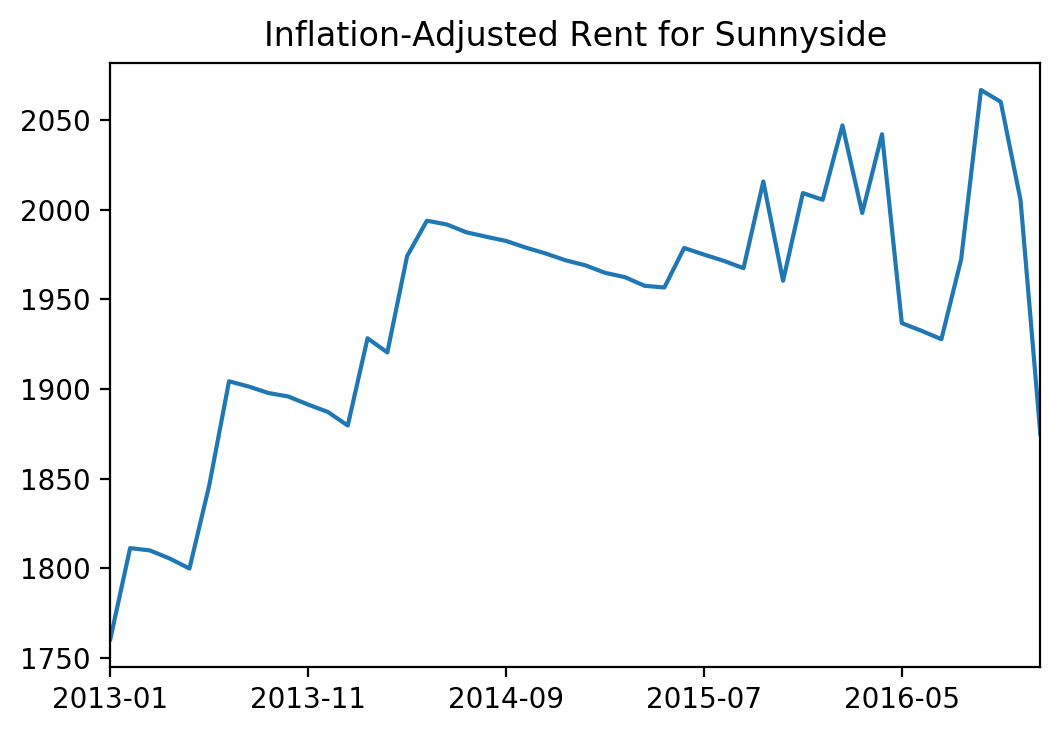

In [185]:
# Get one of the areas' columns
z = zillow_composite
loc = z[z['CompositeId'] == cluster['id']]
rents = loc.drop(['CompositeId'], axis=1).T
x = plt.plot()
ax = rents.plot(ax=plt.gca(), title='Inflation-Adjusted Rent for ' + name, legend=False)
#ax = taxis.plot(ax=plt.gca(), legend=False)

plt.show()

(48, 1)
(48, 1)


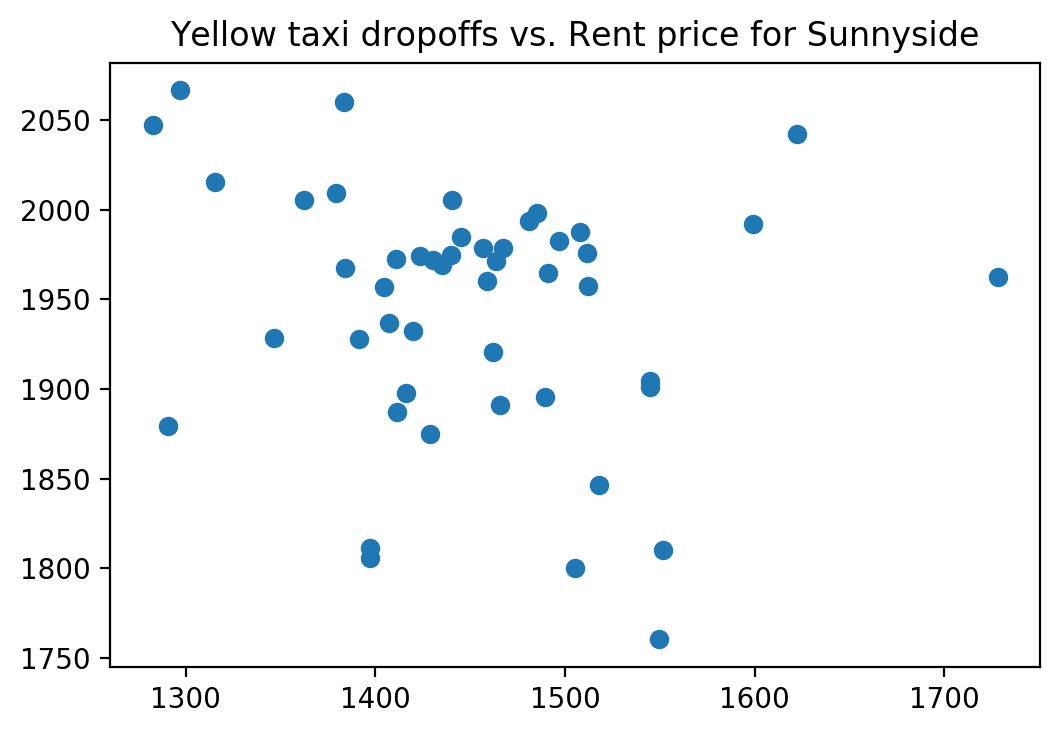

In [186]:
t_array = taxis.as_matrix()
z_array = rents.as_matrix()
print(t_array.shape)
print(z_array.shape)
plt.figure()
plt.scatter(t_array, z_array)
plt.title('Yellow taxi dropoffs vs. Rent price for ' + name)
plt.show()